# Fundamentals of Machine Learning - Exercise 8
Deadline: 2021.02.19, 16:00

Zhao SUN, Johannes Kammerer, Tong Yu

## 2. Non-negative matrix factorization



In [1]:
import numpy as np
import math
import matplotlib . pyplot as plt
%matplotlib inline

from sklearn.datasets import load_digits
from sklearn import decomposition

from IPython.display import display, Markdown, Latex


In [3]:
# load dataset

digits = load_digits ()
X = digits ["data" ]/255.
Y = digits ["target"]

print(X.shape, Y.shape)

(1797, 64) (1797,)


### 2.1 Comparison of scikit-learn’s NMF with SVD (6 Points)

$X$ = $Z$ · $H$ (NMF) - Use at least 10 components for NMF.

$X$ = $U$ · $S$ · $V^T$ (SVD) - Run SVD with full rank and then select the the 6 columns from VT corresponding to
the largest singular values. Must use centered data for SVD

Reshape the selected basis vectors from H and VT into 2D images and plot them.

In [40]:
# NMF
NMF = decomposition.NMF(n_components=10,max_iter=1000) #set to 1000 to ensure convergence
Z = NMF.fit_transform(X)
H = NMF.components_
display(Z.shape, H.shape)

(1797, 10)

(10, 64)

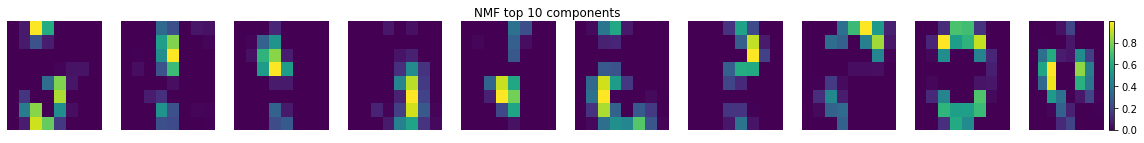

In [37]:
fig,ax = plt.subplots(1,10, figsize=(20,2))
fig.suptitle("NMF top 10 components")
for i in range(10):
    #ax[i].imshow(H[i].reshape(8,8))
    ax[i].axis('off')
    pcm = ax[i].pcolormesh(H[i].reshape(8,8))
fig.colorbar(pcm, ax=ax[i]);

In [11]:
# SVD
X_ = X - X.mean() # centering data first
u,s,vt = np.linalg.svd(X_, full_matrices=True, compute_uv=True, hermitian=False)
display(u.shape, s.shape, vt.shape)

(1797, 1797)

(64,)

(64, 64)

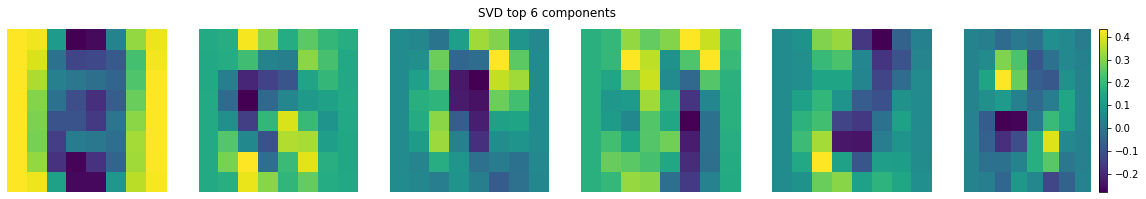

In [36]:
vt_ = vt[:6]+X.mean()

fig,ax = plt.subplots(1,6, figsize=(20,3))
fig.suptitle("SVD top 6 components")

for i in range(6):
    #ax[i].imshow(vt_[i].reshape(8,8))
    ax[i].axis('off')
    pcm = ax[i].pcolormesh(vt_[i].reshape(8,8))

fig.colorbar(pcm, ax=ax[i]);

In [35]:
print(vt_.min(),vt_.max())
print(H.min(),H.max())

-0.3304081481003944 0.43553863791805025
0.0 0.9968197339889581


**Observatons:** 
- SVD has some elements which are negative whereas all NMF elements are non-negative by definition. 
- NMF components seem to be clustering certain similar properties together, e.g. central pixels on top of the image, half circle in the bottom half of the image, etc.) 
- SVD reduced dimension of the data with orthogonal component, which is not necessarily correspondong to any visual similarities.

### 2.2 Implementation (8 Points)

Implement a function non_negative(data, num_components) that calculates a non-negative matrix factorization with these updates, where num_components is the desired number of features M after decomposition. Initialize Z0 and H0 positively, e.g by taking the absolute value of standard normal random variables (RV) with np.random. Iterate until reasonable convergence, e.g. for t = 1000 steps. Note that you might have to ensure numerical stability by avoiding division by zero. You can achieve this by clipping denominators at a small positive value with np.clip. Run your code on the digits data, plot the resulting basis vectors and compare with the NMF results from scikit-learn (results should be similar). Can you confirm that the squared loss is non-increasing as a function of t

In [61]:
def nmf(X, num_components, max_iter=1000, eps_min = 1e-5, eps_max=None):
    """
    Decompose X = Z · H
    num_components = designed number of hidden features after decompoisition
    max_iter = total number of iterations
    eps = floor value to avoid div by zero
    """
    losses = []
    
    # mask
    mask = np.sign(X)

    # initialize Z0 and H0 as non-negative random variables 
    rows, cols = X.shape
    Z = np.abs(np.random.rand(rows, num_components))
    H = np.abs(np.random.rand(num_components,cols))

    masked_X = mask * X
    X_est_prev = np.dot(Z, H)
    
    for i in range(max_iter):
        top = np.dot(masked_X, H.T)
        bottom = np.clip(np.dot((mask * np.dot(Z, H)), H.T), eps_min,eps_max) #clipping to avoid div by zero
        Z *= top / bottom

        top = np.dot(Z.T, masked_X)
        bottom = np.clip(np.dot(Z.T, mask * np.dot(Z, H)), eps_min,eps_max)
        H *= top / bottom

        err = X - np.dot(Z, H)
        loss = np.sum(np.square(err))
        losses.append(loss)
        
        if((i+1) % 100 == 0):
            print(f'Iteration #{i+1}:  squared loss = {loss}')
            
    plt.plot(losses)
    plt.show()

    return Z, H


Iteration #100:  squared loss = 28.813207576588376
Iteration #200:  squared loss = 31.780961413492605
Iteration #300:  squared loss = 37.299957846249704
Iteration #400:  squared loss = 52.37855635508883
Iteration #500:  squared loss = 118.7211992393088
Iteration #600:  squared loss = 300.2386942469526
Iteration #700:  squared loss = 611.0998352018353
Iteration #800:  squared loss = 1010.0089347777755
Iteration #900:  squared loss = 1495.0550199503703
Iteration #1000:  squared loss = 2057.1955007303327


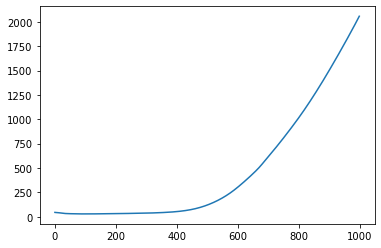

(1797, 10)

(10, 64)

In [71]:
Z, H = nmf(X, num_components=10, max_iter=1000)
display(Z.shape, H.shape)

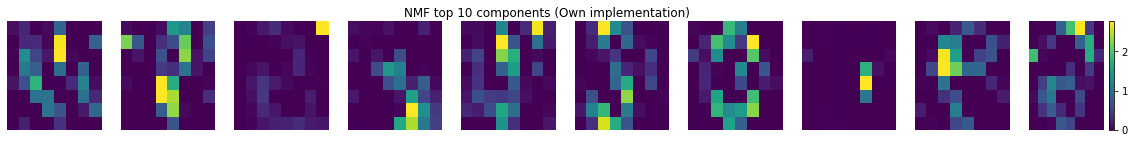

In [72]:
fig,ax = plt.subplots(1,10, figsize=(20,2))
fig.suptitle("NMF top 10 components (Own implementation)")
for i in range(10):
    ax[i].axis('off')
    pcm = ax[i].pcolormesh(H[i].reshape(8,8))
fig.colorbar(pcm, ax=ax[i]);

**Comments**: the squared loss is increasing with t...

## 3 Recommender system (12 Points)

In [188]:
import pandas as pd

# column headers for the dataset
ratings_cols = ['user id','movie id','rating','timestamp']
movies_cols = ['movie id','movie title','release date','video release date','IMDb URL','unknown','Action','Adventure',
               'Animation','Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film - Noir','Horror','Musical',
               'Mystery','Romance','Sci-Fi','Thriller','War','Western']
users_cols = ['user id','age','gender','occupation','zip code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')
movies = pd.read_csv('ml-100k/u.item', sep ='|', names=movies_cols, encoding ='latin-1')
ratings = pd.read_csv('ml-100k/u.data', sep ='\t', names=ratings_cols, encoding ='latin-1')

# peek at the dataframes , if you like :)
display(Markdown('users:'),users.head())
display(Markdown('movies:'),movies.head())
display(Markdown('ratings:'),ratings.head())

# create a joint ratings dataframe for the matrix
fill_value = 0
rat_df = ratings.pivot(index='user id', columns='movie id', values = 'rating'). fillna(fill_value)
display(Markdown('rat_df:'),rat_df.head())

users:

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


movies:

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film - Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


ratings:

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


rat_df:

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


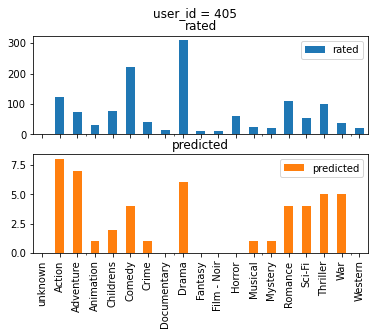

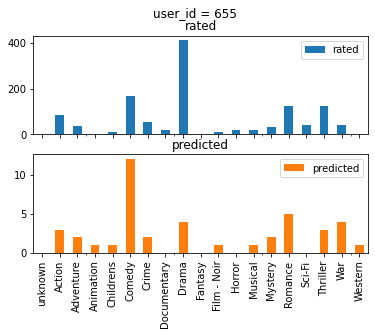

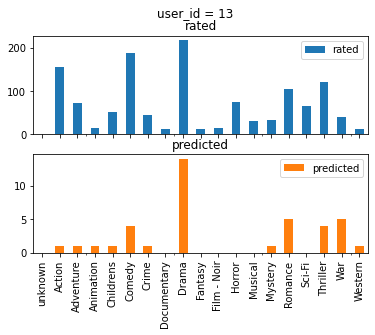

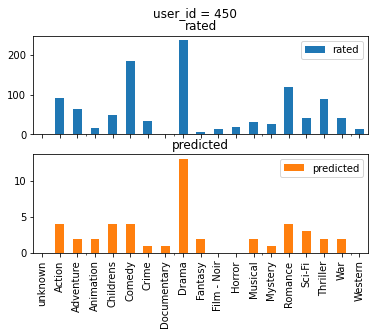

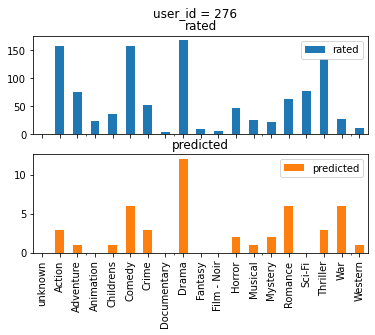

In [189]:
for n in range(2,11,1):
    NMF = decomposition.NMF(n_components=n,max_iter=1000) #set to 1000 to ensure convergence
    Z = NMF.fit_transform(rat_df)
    H = NMF.components_
    X_ = Z@H
    print(f'For {n}-component decomposition, original sparsity: {rat_df[rat_df==0].count().sum()/rat_df.size*100:.1f}%, reconstruction after NMF: {np.sum(X_==0)/X_.size*100:.1f}%')

For 2-component decomposition, original sparsity: 93.7%, reconstruction after NMF: 8.7%
For 3-component decomposition, original sparsity: 93.7%, reconstruction after NMF: 10.2%
For 4-component decomposition, original sparsity: 93.7%, reconstruction after NMF: 10.8%
For 5-component decomposition, original sparsity: 93.7%, reconstruction after NMF: 9.7%
For 6-component decomposition, original sparsity: 93.7%, reconstruction after NMF: 11.7%
For 7-component decomposition, original sparsity: 93.7%, reconstruction after NMF: 13.1%
For 8-component decomposition, original sparsity: 93.7%, reconstruction after NMF: 12.8%
For 9-component decomposition, original sparsity: 93.7%, reconstruction after NMF: 12.3%
For 10-component decomposition, original sparsity: 93.7%, reconstruction after NMF: 12.0%


In [204]:
def recommend_movies(reconstruction, user_id, movies, ratings, top=5):
    """
    give movie recommendations for movies, which user user_id has not yet seen (or at least rated)
    reconstruction = reconstructed matrix from Z@H after NMF decomposition
    user_id = correspond to user_id in the rat_df
    movies = dataframe from 'ml-100k/u.item' 
    ratings = dataframe from 'ml-100k/u.data'
    top = num of recommendations
    
    returns a list of movie recommendations
    """
    predictions = []
    
    candidates = rat_df.loc[user_id]==0 # movies not yet rated by the current user

    recommend = reconstruction.loc[user_id][candidates].sort_values(ascending=False)[:top].index # top n recommendations

    for r in recommend:
        predictions.append(movies[movies['movie id'] == r]['movie title'].item())
    
    return predictions

In [203]:
candidates = rat_df.loc[user_id]==0 # movies not yet rated by the current user
print(candidates)
reconstruction.loc[user_id][candidates].sort_values(ascending=False)[-5:].index # top n recommendations
for r in recommend:
        print(movies[movies['movie id'] == r]['movie title'].item())
    

movie id
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
30       True
31       True
32       True
33       True
34       True
35       True
36       True
37       True
38       True
39       True
40       True
41       True
42       True
43       True
44       True
45       True
46       True
47       True
48       True
49       True
50       True
51       True
52       True
53       True
54       True
55       True
56       True
57       True
58       True
59       True
60       True
61       True
62       True
63       True
64       True
65       True
66       True
67       True
68       True
69       True
70       True
71       Tr

In [205]:
# Choose n = 5
n = 5
NMF = decomposition.NMF(n_components=n,max_iter=1000) #set to 1000 to ensure convergence
Z = NMF.fit_transform(rat_df)
H = NMF.components_
X_ = Z@H

user_id = 100
reconstruction = pd.DataFrame(X_, columns=rat_df.columns, index=rat_df.index)
predictions = recommend_movies(reconstruction, user_id, movies, ratings)
predictions

["Devil's Advocate, The (1997)",
 'In & Out (1997)',
 'Cop Land (1997)',
 'Kiss the Girls (1997)',
 'Saint, The (1997)']

Add some ratings for additional users (yourself) and check if the resulting recommendations make sense.

In [157]:
pd.set_option('display.max_rows', movies.shape[0]+1)
movies[['movie id','movie title']]

,movie id,movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6,7,Twelve Monkeys (1995)
7,8,Babe (1995)
8,9,Dead Man Walking (1995)
9,10,Richard III (1995)


In [206]:
# add new user ratings 
claire_ratings = np.zeros(len(movies))
claire_ratings[[1414,87,93,0,4,7]]=5 
claire = pd.DataFrame(claire_ratings.reshape(1,-1), columns=rat_df.columns)
rat_df = rat_df.append(claire) 
rat_df.tail(3)

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
943,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
# Perform NMF on new dataframe with added ratings. Run recommendation for added user
n = 5
NMF = decomposition.NMF(n_components=n,max_iter=1000) #set to 1000 to ensure convergence
Z = NMF.fit_transform(rat_df)
H = NMF.components_
X_ = Z@H

user_id = 0
reconstruction = pd.DataFrame(X_, columns=rat_df.columns, index=rat_df.index)
predictions = recommend_movies(reconstruction, user_id, movies, ratings)
predictions

['Return of the Jedi (1983)',
 'Star Wars (1977)',
 'Lion King, The (1994)',
 'Forrest Gump (1994)',
 'Independence Day (ID4) (1996)']

**COMMENTS**
- Recommendation seems very reasonable. 
- I have rated the following movies with 5: Toy story, Copycat, Babe, Home Alone, Sleepless in Seatle, The Next Karate Kid
- Expected recommendations to be related to childrens / drama 
- Quite satisfied with recommendation because these are actually movies I have watched and liked!

Show (e.g. with histograms) that the “genre-statistics” vary between already rated movies and predicted movies (e.g. with 20 predictions) for selected users. What is the difference and how do you explain it? Also try to identify rows in H that can be interpreted as prototypical user preferences (e.g. “comedy fan”).

**Top 5 users:**

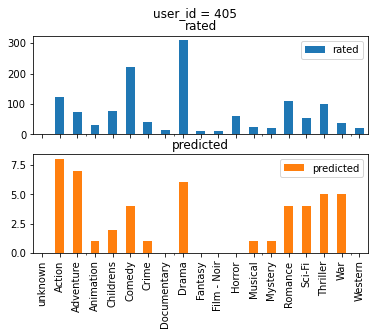

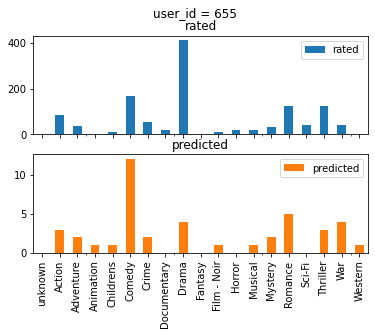

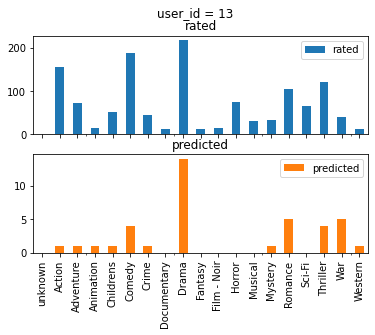

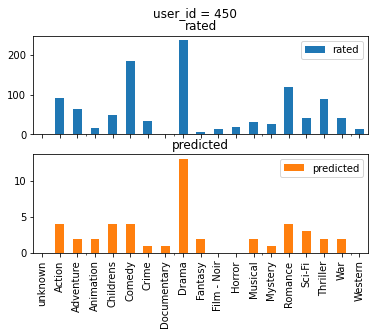

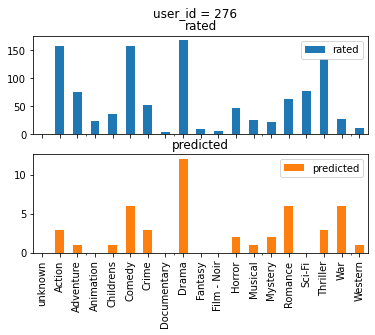

In [246]:
user_rating = ratings.groupby('user id')['rating'].count().sort_values(ascending=False)
top_users = user_rating[:5].index
bottom_users = user_rating[-5:].index

most_rated_movies = ratings.groupby('movie id')['rating'].count().sort_values(ascending=False)[:20]

genres = ['unknown','Action','Adventure','Animation','Childrens','Comedy','Crime','Documentary','Drama','Fantasy',
          'Film - Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

display(Markdown("**Top 5 users:**"))
for user_id in top_users:
    rated_movies = ratings[ratings['user id']==user_id]['movie id']
    x = pd.DataFrame(index=genres)
    x['rated'] = movies[movies['movie id'].isin(rated_movies)][genres].sum()
    predictions = predictions = recommend_movies(reconstruction, user_id, movies, ratings, top=20)
    x['predicted'] = movies[movies['movie title'].isin(predictions)][genres].sum()
    x.plot.bar(title=f'user_id = {user_id}', subplots=True)


**Bottom 5 users:**

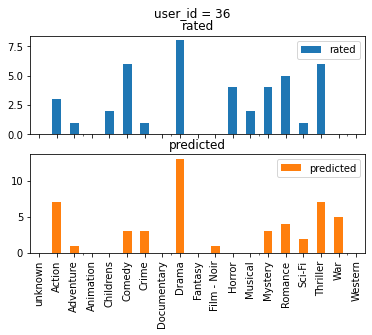

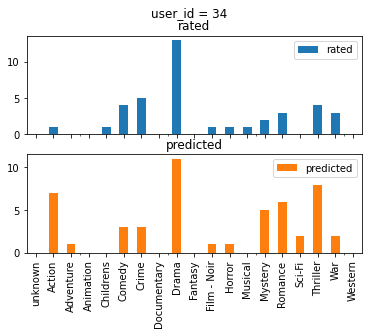

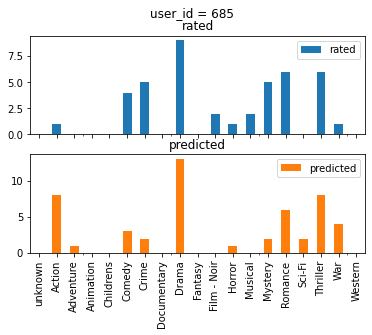

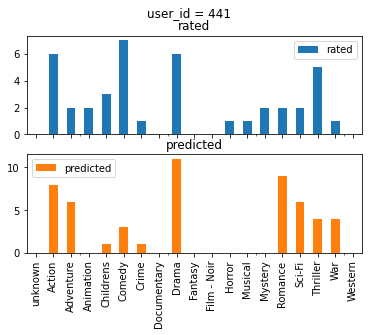

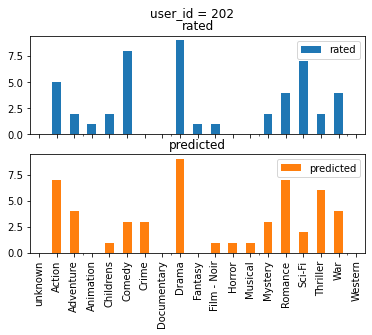

In [247]:
display(Markdown("**Bottom 5 users:**"))
for user_id in bottom_users:
    rated_movies = ratings[ratings['user id']==user_id]['movie id']
    x = pd.DataFrame(index=genres)
    x['rated'] = movies[movies['movie id'].isin(rated_movies)][genres].sum()
    predictions = predictions = recommend_movies(reconstruction, user_id, movies, ratings, top=20)
    x['predicted'] = movies[movies['movie title'].isin(predictions)][genres].sum()
    x.plot.bar(title=f'user_id = {user_id}', subplots=True)


**Observations:** Predictions do not necessarily follow the same genre distribution as the movies already rated by the user. This is probably due to the fact that the use might have different ratings for all the movies he/she has rated, e.g. a use might rated a lot of movies in a genre with low ratings and for anothre genre only selected few movies but with high ratings. This user preference might have been picked up by the recommendation function as we select the highest ranked values, hence the discrpency in number distribution by genre.

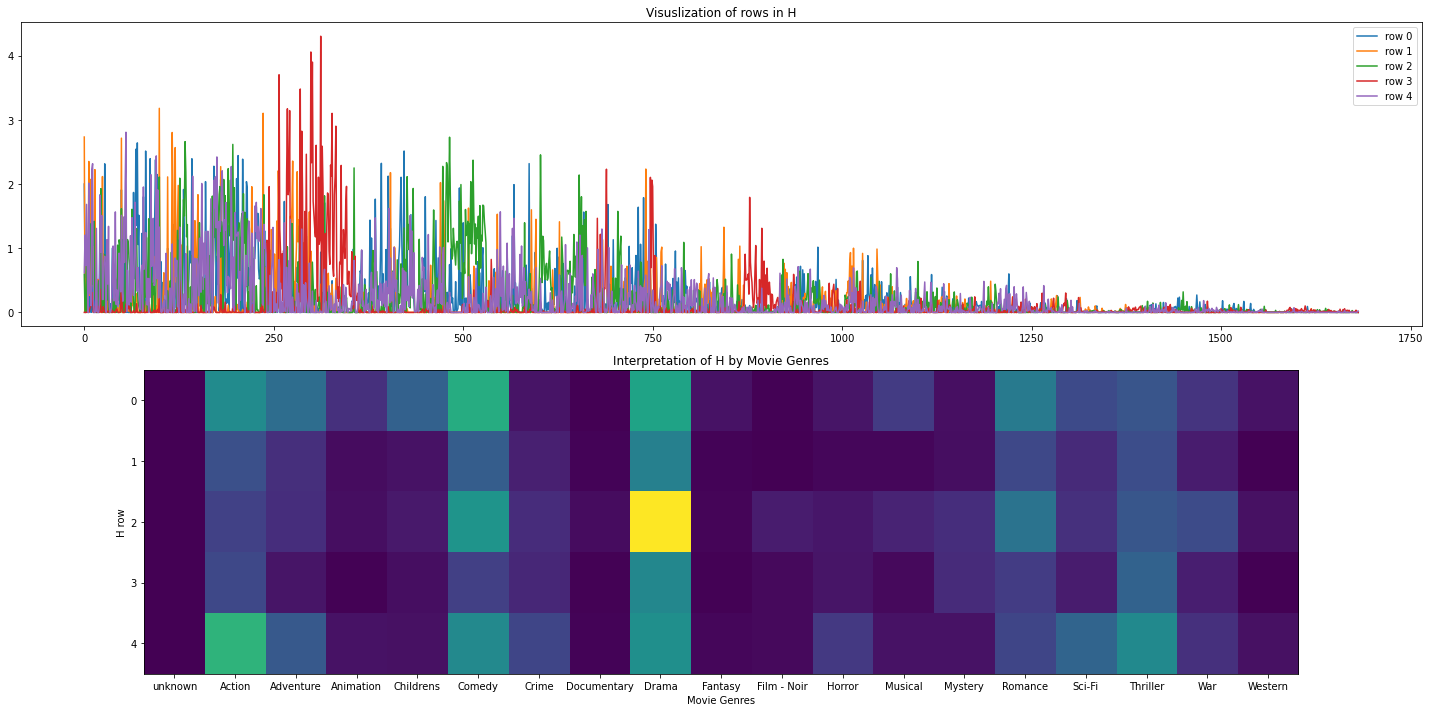

In [274]:
#  Also try to identify rows in H that can be interpreted as prototypical user preferences (e.g. “comedy fan”).
out = H.dot(np.array(movies[genres]))
fig, ax = plt.subplots(2,1,figsize=(20,10), tight_layout=True)

ax[0].set_title("Visuslization of rows in H")
for i in range(H.shape[0]):
    ax[0].plot(H[i], label=f'row {i}')
ax[0].legend()

    
ax[1].set_title("Interpretation of H by Movie Genres")
ax[1].imshow(out)
ax[1].set_xticks(np.arange(len(genres)))
ax[1].set_xticklabels(genres)
ax[1].set_xlabel('Movie Genres')
ax[1].set_ylabel('H row');

**Interpretation of H:** Based on the above heatmap, the prototypical user preferences are
- Row 0: Comedy-drama
- Row 1: *(no clear signal)*
- Row 2: Drama
- Row 3: *(no clear signal)*
- Row 4: Action-Thriller
